**Import all the required libraries**

In [2]:
#import all the libraries 
import pandas as pd
import numpy as np
import requests
!pip install beautifulsoup4
from bs4 import BeautifulSoup
!pip install folium==0.5.0
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install geopy
!pip install lxml
!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
!pip install yellowbrick
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

<h1 align=center><font color="Black" >Selection of Potential Neighborhoods in Kuala Lumpur for New GYM  </font>

## Table of Content

<font size=3.5>
   
* [Introduction](#introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Results & Discussion](#Results)
* [Conclusion](#Conclusion)
    </font>

## **Introduction** <a id='introduction'></a>

### Business Problem

An investor is looking to open a new gym in Kuala Lumpur. Based on his previous experiences and marketing strategy, he would like to tap-into a mature neighborhood with high traffic, but low competition. He has listed down the area selection criteria as shown below:

* Area that has hotels or shopping mall or residential (apartments or condo) in vicinity. 
* Area that is not already crowded with gyms

This project is carried out to answer the investor's question, that is to locate a potential neighborhood in Kuala Lumpur.  

### Stakeholders

Besides the investor who initiate this project, there are some other stakeholders who might be interested in this project:


* Those that are interested in knowing high traffic attraction areas in Kuala Lumpur
* Those that are interested in knowing the area with sports amenities in Kuala Lumpur
* Those that have interest in using the exploration result in this project


## **Data** <a id='Data'></a>

Based on the business problem, we would require the following data in this project. 

* [Neighborhood list of Kuala Lumpur](#kl)
* [Coordinates of each neighborhood](#co)
* [Venues in each neighborhood](#foursquare)


### Neighborhood list of Kuala Lumpur <a id='kl'></a>

First, we gather the information of neighborhoods in Kuala Lumpur. 

This link below contains the list of neighborhoods in Kuala Lumpur. Web scraping technique is applied here to capture these information.

In [3]:
# Perform web scraping
url='https://en.wikipedia.org/wiki/Category:Suburbs_in_Kuala_Lumpur'
result=requests.get(url)
soup=BeautifulSoup(result.content,"html.parser")
data=soup.find_all("div",{"class":'mw-category'})[0].findAll('li')

In [6]:
#lets transfer these data into a list
Neighborhood=[]
for i in range(len(data)):
    Neighborhood.append(data[i].text)

In [7]:
#Let's transfer this list into a Pandas data frame
kl=pd.DataFrame(Neighborhood)

#Let's take a look on the data frame
print (" The shape of data frame is: ",kl.shape)
kl.head()

 The shape of data frame is:  (71, 1)


,0
0,Alam Damai
1,"Ampang, Kuala Lumpur"
2,Bandar Menjalara
3,Bandar Sri Permaisuri
4,Bandar Tasik Selatan


In [8]:
#Rename the column 0 to Neighborhood
kl.rename(columns={0:"Neighborhood"},inplace=True)

## Coordinates of each Neighborhood <a id='co'></a>

Now that we have the list of neighborhoods in Kuala Lumpur, the next step will be to get the coordinates for each of the neighborhood. This process is realized with geocoding library.

In [9]:
#let's define a function to get the coordinate
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Kuala Lumpur, Malaysia'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [10]:
#Now apply the function abaove to get the coordinate for each of the neighborhood in Kuala Lumpur
area = kl['Neighborhood']    
coords = [ get_latlng(neighborhood) for neighborhood in area.tolist() ]

#To add the columns Latitude and Longitude into kl data frame

df_kl_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
kl['Latitude'] = df_kl_coords['Latitude']
kl['Longitude'] = df_kl_coords['Longitude']
kl.head()

,Neighborhood,Latitude,Longitude
0,Alam Damai,3.057690,101.743880
1,"Ampang, Kuala Lumpur",3.148494,101.696729
2,Bandar Menjalara,3.190350,101.625450
3,Bandar Sri Permaisuri,3.103910,101.712260
4,Bandar Tasik Selatan,3.072750,101.714610


## Venues in each neighborhoods <a id='foursquare'></a>

We will use Foursquare location data to get the venues list in each neighborhood. For now, let's explore each neighborhood. 

In [16]:
# @hidden_cell
CLIENT_ID = 'H3XZAJV3K1OHHKLEX1ENASISST1WBDDW5TNMEJZJQ1ORWMS4' 
CLIENT_SECRET = '0ELVDXQDZEVJRRE1V2GP41VKYSE120EXVM2IGFZTYCTIQVLC' 
VERSION = '20200130' # Foursquare API version

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['shortName']) for v in results]) #by BW

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Main Category']
    
    return(nearby_venues)

Run the above function, and put the output into a new data frame.

In [17]:
#let's put limit=200 & radius to be 1500m
LIMIT=200

kl_ven=getNearbyVenues(names=kl['Neighborhood'],latitudes=kl['Latitude'],longitudes=kl['Longitude'])

Alam Damai
Ampang, Kuala Lumpur
Bandar Menjalara
Bandar Sri Permaisuri
Bandar Tasik Selatan
Bandar Tun Razak
Bangsar
Bangsar Park
Bangsar South
Batu 11 Cheras
Batu, Kuala Lumpur
Brickfields
Bukit Bintang
Bukit Jalil
Bukit Kiara
Bukit Nanas
Bukit Petaling
Bukit Tunku
Cheras, Kuala Lumpur
Chow Kit
Damansara Heights
Damansara Town Centre
Damansara, Kuala Lumpur
Dang Wangi
Desa Petaling
Federal Hill, Kuala Lumpur
Happy Garden
Jalan Cochrane, Kuala Lumpur
Jalan Duta
Jinjang
Kampung Baru, Kuala Lumpur
Kampung Datuk Keramat
Kampung Padang Balang
Kepong
KL Eco City
Kuchai Lama
Lembah Pantai
Maluri
Medan Tuanku
Miharja
Mont Kiara
Pantai Dalam
Pudu, Kuala Lumpur
Putrajaya
Salak South
Segambut
Semarak
Sentul, Kuala Lumpur
Setapak
Setiawangsa
Shamelin
Sri Hartamas
Sri Petaling
Sungai Besi
Taman Bukit Maluri
Taman Cheras Hartamas
Taman Connaught
Taman Desa
Taman Ibukota
Taman Len Seng
Taman Melati
Taman Midah
Taman OUG
Taman P. Ramlee
Taman Sri Sinar
Taman Taynton View
Taman Tun Dr Ismail
Taman U-T

**Let's check the size of the resulting data frame.**

In [18]:
print(kl_ven.shape)
kl_ven.head()

(6762, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Main Category
0,Alam Damai,3.05769,101.74388,Pengedar Shaklee Kuala Lumpur,3.061235,101.740696,Supplement Shop,Supplement Shop
1,Alam Damai,3.05769,101.74388,Jc Deli 皆喜食坊,3.058397,101.748560,Food & Drink Shop,Food & Drink
2,Alam Damai,3.05769,101.74388,Machi Noodle 妈子面,3.057695,101.746635,Noodle House,Noodles
3,Alam Damai,3.05769,101.74388,628火焰鑫茶室,3.058442,101.747947,Chinese Restaurant,Chinese
4,Alam Damai,3.05769,101.74388,Minang Tomyam,3.057185,101.749812,Seafood Restaurant,Seafood


Let's check how many venues were returned for each neighborhood.

In [19]:
kl_ven.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Main Category
Neighborhood,,,,,,,
Alam Damai,76,76,76,76,76,76,76
"Ampang, Kuala Lumpur",100,100,100,100,100,100,100
Bandar Menjalara,100,100,100,100,100,100,100
Bandar Sri Permaisuri,100,100,100,100,100,100,100
Bandar Tasik Selatan,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...
Taman Tun Dr Ismail,100,100,100,100,100,100,100
Taman U-Thant,100,100,100,100,100,100,100
Taman Wahyu,47,47,47,47,47,47,47


## **Methodology** <a id='Methodology'></a>

Below are the methodologies used in this project.

* [Pre-processing](#pre)
* [Clustering](#clustering)
* [Visualization with Folium map](#map)
* [Examine the cluster](#bar)
* [Sub-clustering](#sub)

### Pre-processing <a id='pre'></a>

* [Filtering the DataFrame](#filter)
* [One-hot encoding](#one)
* [GroupBy](#group)

**Filtering the DataFrame**<a id='filter'></a>

Our target location is the neighborhood with the following conditions:

* Area that is not already crowded with gyms
* Area that has hotels or shopping mall or residentials (apartments or condo) in vicinity

Now, let's filter the kl_ven dataframe to only these venue categories:

* Gym
* Sports
* Shopping mall
* Hotel
* Residential

In [22]:
kl_selected=kl_ven[kl_ven['Venue Main Category'].str.contains('Sports')|kl_ven['Venue Main Category'].str.contains('Gym')|kl_ven['Venue Main Category'].str.contains('Hotel')|kl_ven['Venue Main Category'].str.contains('Mall')|kl_ven['Venue Main Category'].str.contains('Residential')]
kl_selected.reset_index(inplace=True)
kl_selected

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Main Category
0,87,"Ampang, Kuala Lumpur",3.148494,101.696729,Adya Hotel Kuala Lumpur,3.151703,101.695623,Hotel,Hotel
1,94,"Ampang, Kuala Lumpur",3.148494,101.696729,Menara Maybank Recreation Centre,3.147267,101.699464,Gym,Gym
2,116,"Ampang, Kuala Lumpur",3.148494,101.696729,"Peak Fitness, KLSOGO",3.156037,101.694898,Gym,Gym
3,117,"Ampang, Kuala Lumpur",3.148494,101.696729,The Majestic Hotel,3.139277,101.692242,Hotel,Hotel
4,123,"Ampang, Kuala Lumpur",3.148494,101.696729,"Shangri-La Hotel, Kuala Lumpur",3.154250,101.706320,Hotel,Hotel
...,...,...,...,...,...,...,...,...,...
456,6679,Wangsa Maju,3.203910,101.737190,Celebrity Fitness Express,3.199398,101.742204,Gym,Gym
457,6708,Wangsa Maju,3.203910,101.737190,Melawati Mall,3.210520,101.748502,Shopping Mall,Mall
458,6714,Wangsa Maju,3.203910,101.737190,Ultimate Gym - Serious Fitness,3.197616,101.745300,Gym / Fitness Center,Gym / Fitness
459,6718,Wangsa Maju,3.203910,101.737190,Fitness First Platinum,3.211277,101.748506,Gym,Gym


Let's check the type of venues returned.

In [92]:
kl_selected['Venue Main Category'].unique()

array(['Hotel', 'Gym', 'Hotel Bar', 'Mall', 'Residential',
       'Athletics & Sports', 'Gym / Fitness', 'Sports Bar', 'Sports Club',
       'Boxing Gym'], dtype=object)

From above, we can see that there are 2 categories which are not in our interest group.  They are "Hotel Bar" and "Sports Bar". Let's drop these from the dataframe.

In [111]:
kl_selected=kl_selected[kl_selected['Venue Main Category']!='Sports Bar']
kl_selected=kl_selected[kl_selected['Venue Main Category']!='Hotel Bar']
kl_selected.reset_index(drop=True,inplace=True)
kl_selected

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Main Category
0,87,"Ampang, Kuala Lumpur",3.148494,101.696729,Adya Hotel Kuala Lumpur,3.151703,101.695623,Hotel,Hotel
1,94,"Ampang, Kuala Lumpur",3.148494,101.696729,Menara Maybank Recreation Centre,3.147267,101.699464,Gym,Gym
2,116,"Ampang, Kuala Lumpur",3.148494,101.696729,"Peak Fitness, KLSOGO",3.156037,101.694898,Gym,Gym
3,117,"Ampang, Kuala Lumpur",3.148494,101.696729,The Majestic Hotel,3.139277,101.692242,Hotel,Hotel
4,123,"Ampang, Kuala Lumpur",3.148494,101.696729,"Shangri-La Hotel, Kuala Lumpur",3.154250,101.706320,Hotel,Hotel
...,...,...,...,...,...,...,...,...,...
423,6679,Wangsa Maju,3.203910,101.737190,Celebrity Fitness Express,3.199398,101.742204,Gym,Gym
424,6708,Wangsa Maju,3.203910,101.737190,Melawati Mall,3.210520,101.748502,Shopping Mall,Mall
425,6714,Wangsa Maju,3.203910,101.737190,Ultimate Gym - Serious Fitness,3.197616,101.745300,Gym / Fitness Center,Gym / Fitness
426,6718,Wangsa Maju,3.203910,101.737190,Fitness First Platinum,3.211277,101.748506,Gym,Gym


**One-hot encoding** <a id='one'></a>

We perform one hot encoding to convert the categorical variables into a form that could be provided to ML algorithms to do a better job in prediction

In [112]:
#One hot encoding
kl_dum=pd.get_dummies(kl_selected[['Venue Main Category']],prefix="",prefix_sep="")

#Create dataframe consists of only column Neighborhood
kl_one=kl_selected[['Neighborhood']]

# Merge the dummies into the dataframe created
kl_one=kl_one.merge(kl_dum,left_index=True,right_index=True)

kl_one.head()

,Neighborhood,Athletics & Sports,Boxing Gym,Gym,Gym / Fitness,Hotel,Mall,Residential,Sports Club
0,"Ampang, Kuala Lumpur",0,0,0,0,1,0,0,0
1,"Ampang, Kuala Lumpur",0,0,1,0,0,0,0,0
2,"Ampang, Kuala Lumpur",0,0,1,0,0,0,0,0
3,"Ampang, Kuala Lumpur",0,0,0,0,1,0,0,0
4,"Ampang, Kuala Lumpur",0,0,0,0,1,0,0,0


**GroupBy** <a id='group'></a>

Let's group the row by neighborhood and sum of each category.

In [113]:
#group by sum
kl_grp_sum=kl_one.groupby('Neighborhood').sum().reset_index()
kl_grp_sum

,Neighborhood,Athletics & Sports,Boxing Gym,Gym,Gym / Fitness,Hotel,Mall,Residential,Sports Club
0,"Ampang, Kuala Lumpur",0,0,2,0,9,0,0,0
1,Bandar Menjalara,0,0,3,0,0,1,0,0
2,Bandar Sri Permaisuri,1,0,1,0,0,0,2,0
3,Bandar Tasik Selatan,1,0,1,1,1,1,1,0
4,Bandar Tun Razak,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
63,Taman Tun Dr Ismail,0,0,0,2,1,3,0,0
64,Taman U-Thant,0,0,0,2,12,2,0,0
65,Taman Wahyu,0,0,0,0,1,0,1,0
66,Titiwangsa,1,0,1,0,2,0,0,0


Let's calculate the mean of each category in each neighborhood.

In [114]:
#group by mean
kl_grp_mean=kl_one.groupby('Neighborhood').mean().reset_index()
kl_grp_mean

,Neighborhood,Athletics & Sports,Boxing Gym,Gym,Gym / Fitness,Hotel,Mall,Residential,Sports Club
0,"Ampang, Kuala Lumpur",0.000000,0.0,0.181818,0.000000,0.818182,0.000000,0.000000,0.0
1,Bandar Menjalara,0.000000,0.0,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
2,Bandar Sri Permaisuri,0.250000,0.0,0.250000,0.000000,0.000000,0.000000,0.500000,0.0
3,Bandar Tasik Selatan,0.166667,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.0
4,Bandar Tun Razak,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
63,Taman Tun Dr Ismail,0.000000,0.0,0.000000,0.333333,0.166667,0.500000,0.000000,0.0
64,Taman U-Thant,0.000000,0.0,0.000000,0.125000,0.750000,0.125000,0.000000,0.0
65,Taman Wahyu,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.500000,0.0
66,Titiwangsa,0.250000,0.0,0.250000,0.000000,0.500000,0.000000,0.000000,0.0


### Clustering <a id='clustering'></a>

* [Preparation](#preparation)
* [kelbow_visualizer](#kelbow)
* [KMeans Clustering](#cluster)


**We will cluster the neighborhoods by K Means Clustering algorithm.**

Let's prepare the data for clustering. <a id='preparation'></a>

In [115]:
#prepare dataframe for clustering
kl_grp_cluster=kl_grp_mean.drop(columns='Neighborhood',axis=1)
kl_grp_cluster.head()

,Athletics & Sports,Boxing Gym,Gym,Gym / Fitness,Hotel,Mall,Residential,Sports Club
0,0.000000,0.0,0.181818,0.000000,0.818182,0.000000,0.000000,0.0
1,0.000000,0.0,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
2,0.250000,0.0,0.250000,0.000000,0.000000,0.000000,0.500000,0.0
3,0.166667,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.0
4,0.000000,0.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.0


We will use elbow method to find the appropriate number of cluster.<a id='kelbow'></a>

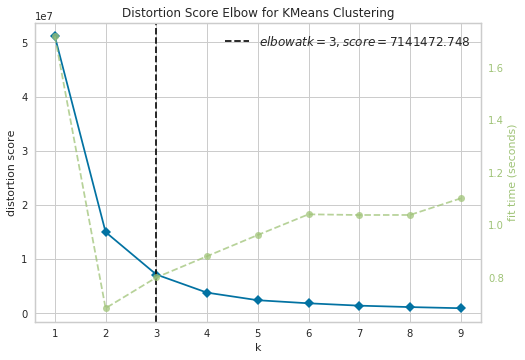

In [182]:
#to find the appropriate cluster number by elbow method
X, y = load_nfl()
model=kelbow_visualizer(KMeans(),X,k=(1,10))
model.fit(kl_grp_cluster)
model.poof()

**As shown in the graph above, 3 is the good choice for cluster number. Let's re-run KMeans clustering by setting k=3.** <a id='cluster'></a>

In [117]:
km=KMeans(n_clusters=3)
km.fit(kl_grp_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

**Lets insert the cluster label into the dataframe**

In [118]:
# add clustering labels
kl_grp_sum.insert(0,"Cluster Label",km.labels_)

In [133]:
# create new dataframe
kl_complete=kl_grp_sum.join(kl.set_index('Neighborhood'), on='Neighborhood')

In [134]:
kl_complete

,Cluster Label,Neighborhood,Athletics & Sports,Boxing Gym,Gym,Gym / Fitness,Hotel,Mall,Residential,Sports Club,Latitude,Longitude
0,1,"Ampang, Kuala Lumpur",0,0,2,0,9,0,0,0,3.148494,101.696729
1,2,Bandar Menjalara,0,0,3,0,0,1,0,0,3.190350,101.625450
2,0,Bandar Sri Permaisuri,1,0,1,0,0,0,2,0,3.103910,101.712260
3,0,Bandar Tasik Selatan,1,0,1,1,1,1,1,0,3.072750,101.714610
4,2,Bandar Tun Razak,0,0,1,1,0,0,0,0,3.082800,101.722810
...,...,...,...,...,...,...,...,...,...,...,...,...
63,0,Taman Tun Dr Ismail,0,0,0,2,1,3,0,0,3.152830,101.622710
64,1,Taman U-Thant,0,0,0,2,12,2,0,0,3.157700,101.724520
65,1,Taman Wahyu,0,0,0,0,1,0,1,0,3.222400,101.671730
66,1,Titiwangsa,1,0,1,0,2,0,0,0,3.180730,101.703210


In [135]:
#re-arrange the column in data frame kl_complete

#define the order
clm=list(kl_complete.columns)
order=[0,1,-2,-1,2,3,4,5,6,7,8,9]
clm_order=[clm[i] for i in order]

#re-arrange the column
kl_complete=kl_complete.reindex(columns=clm_order)
kl_complete

,Cluster Label,Neighborhood,Latitude,Longitude,Athletics & Sports,Boxing Gym,Gym,Gym / Fitness,Hotel,Mall,Residential,Sports Club
0,1,"Ampang, Kuala Lumpur",3.148494,101.696729,0,0,2,0,9,0,0,0
1,2,Bandar Menjalara,3.190350,101.625450,0,0,3,0,0,1,0,0
2,0,Bandar Sri Permaisuri,3.103910,101.712260,1,0,1,0,0,0,2,0
3,0,Bandar Tasik Selatan,3.072750,101.714610,1,0,1,1,1,1,1,0
4,2,Bandar Tun Razak,3.082800,101.722810,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
63,0,Taman Tun Dr Ismail,3.152830,101.622710,0,0,0,2,1,3,0,0
64,1,Taman U-Thant,3.157700,101.724520,0,0,0,2,12,2,0,0
65,1,Taman Wahyu,3.222400,101.671730,0,0,0,0,1,0,1,0
66,1,Titiwangsa,3.180730,101.703210,1,0,1,0,2,0,0,0


**Let's visualize the cluster in map** <a id='map'></a>

First, let's get the coordinate of Kuala Lumpur.

In [136]:
#Lets get the coordinates of KL
address="Kuala Lumpur"
geolocator = Nominatim(user_agent="kl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Kuala Lumpur are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Kuala Lumpur are 3.1516964, 101.6942371.


Now, visualize the distribution of clusters on map.

In [137]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
color_choice=['red','orange','blue']


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_complete['Latitude'], kl_complete['Longitude'],kl_complete['Neighborhood'], kl_complete['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=color_choice[cluster],
        fill=True,
        fill_color=color_choice[cluster],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

## Examine the cluster <a id='bar'></a>

First, let's visualize the bar chart for the total number of each venue in each cluster.

In [138]:
#let's prepare the dataframe for bar chart visualization
bar=kl_grp_sum.drop(columns='Neighborhood',axis=1)
bar=bar.groupby('Cluster Label').sum()
bar=bar.T
bar

Cluster Label,0,1,2
Athletics & Sports,12,8,0
Boxing Gym,2,0,0
Gym,16,20,16
Gym / Fitness,36,17,4
Hotel,10,204,1
Mall,22,41,1
Residential,12,3,1
Sports Club,2,0,0


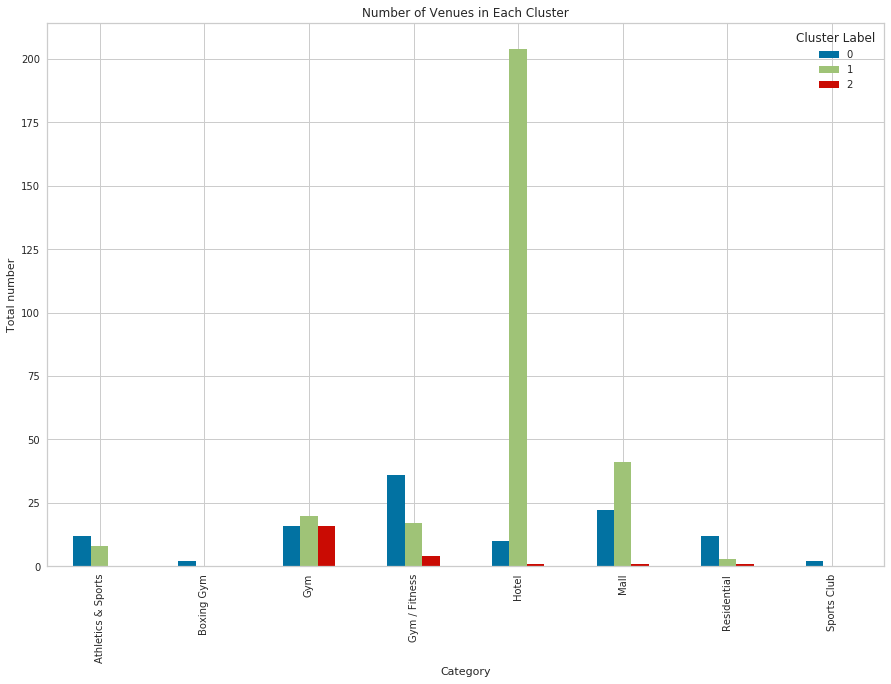

In [139]:
#let's plot the bar chart
bar.plot(kind='bar',figsize=(15,10))
plt.xlabel('Category')
plt.ylabel('Total number')
plt.title("Number of Venues in Each Cluster")
plt.show()

It seems like cluster 1 fit our requirements. The numbers of hotels & malls are much higher as compared to other clusters, while the number of gyms are on the same level with other cluster. 

### Sub-clustering <a id='sub'></a>

* [Preparation](#subpre)
* [Sub-clustering](#subclus)
* [Visualization of sub-cluster on map](#vizsub)
* [Examine sub-clusters](#exsub)

**let's explore cluster 1 further!**

Gather the information of cluster 1 <a id='subpre'></a>

In [173]:
cls1=kl_grp_sum.loc[kl_grp_sum['Cluster Label'] == 1]
cls1.reset_index(drop=True,inplace=True)
cls1.head()

,Cluster Label,Neighborhood,Athletics & Sports,Boxing Gym,Gym,Gym / Fitness,Hotel,Mall,Residential,Sports Club
0,1,"Ampang, Kuala Lumpur",0,0,2,0,9,0,0,0
1,1,Bangsar,0,0,0,0,5,5,0,0
2,1,Bangsar Park,0,0,0,0,5,5,0,0
3,1,Bangsar South,0,0,0,2,4,1,1,0
4,1,"Batu, Kuala Lumpur",0,0,2,0,7,0,0,0


**Let's separate the venues into two categories:**

* Traffic 
* Sports

In [161]:
sports=['Neighborhood','Athletics & Sports','Boxing Gym','Gym','Gym / Fitness','Sports Club']
traffic=['Neighborhood','Hotel', 'Mall', 'Residential']

Add two columns (Sports Total & Traffic Total)  into the existing dataframe

In [174]:
cls1['Traffic Total']=cls1[traffic].sum(axis=1)
cls1['Sports Total']=cls1[sports].sum(axis=1)
cls1.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Cluster Label,Neighborhood,Athletics & Sports,Boxing Gym,Gym,Gym / Fitness,Hotel,Mall,Residential,Sports Club,Traffic Total,Sports Total
0,1,"Ampang, Kuala Lumpur",0,0,2,0,9,0,0,0,9,2
1,1,Bangsar,0,0,0,0,5,5,0,0,10,0
2,1,Bangsar Park,0,0,0,0,5,5,0,0,10,0
3,1,Bangsar South,0,0,0,2,4,1,1,0,6,2
4,1,"Batu, Kuala Lumpur",0,0,2,0,7,0,0,0,7,2


For easier comparison, let's clean the dataframe to only 3 columns:
* Neighborhood
* Sports Total
* Traffic Total.

In [179]:
cls1_cleaned=cls1[['Neighborhood','Traffic Total','Sports Total']]
cls1_cleaned.head()


,Neighborhood,Traffic Total,Sports Total
0,"Ampang, Kuala Lumpur",9,2
1,Bangsar,10,0
2,Bangsar Park,10,0
3,Bangsar South,6,2
4,"Batu, Kuala Lumpur",7,2


Let's perform clustering again within cluster 1.

In [180]:
#clean dataframe for clustering
cls1_cluster=cls1_cleaned[['Traffic Total','Sports Total']]
cls1_cluster.head()

,Traffic Total,Sports Total
0,9,2
1,10,0
2,10,0
3,6,2
4,7,2


**Sub-clustering**<a id='subclus'></a>

Text(0, 0.5, 'Sum of squared distance')

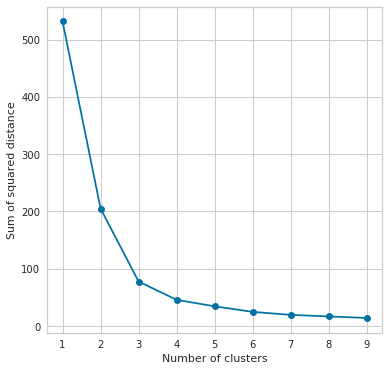

In [185]:
# find the suitable cluster number

sse=[]
list_k=list(range(1,10))

for k in list_k:
    km=KMeans(n_clusters=k)
    km.fit(cls1_cluster)
    sse.append(km.inertia_)
    
# Plot sse against k
plt.figure(figsize=(6,6))
plt.plot(list_k,sse,'-o')
plt.xlabel('Number of clusters')
plt.ylabel("Sum of squared distance")

In [187]:
#Run the KMeans clustering with k=3
km1=KMeans(n_clusters=3)
km1.fit(cls1_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [188]:
#add clustering label into dataframe cls1_cleaned
cls1_cleaned.insert(1,'Sub-Cluster label',km1.labels_)
cls1_cleaned

,Neighborhood,Sub-Cluster label,Traffic Total,Sports Total
0,"Ampang, Kuala Lumpur",1,9,2
1,Bangsar,1,10,0
2,Bangsar Park,1,10,0
3,Bangsar South,1,6,2
4,"Batu, Kuala Lumpur",1,7,2
5,Brickfields,1,10,2
6,Bukit Bintang,0,15,1
7,Bukit Nanas,0,12,4
8,Bukit Petaling,1,7,1
9,Bukit Tunku,1,6,2


**Visualzation of Sub-Cluster** <a id='vizsub'></a>

Visualize the cluster on map.

In [191]:
#add in coordinates for each neighborhood
cls1_cleaned_complete=cls1_cleaned.join(kl.set_index('Neighborhood'),on='Neighborhood')
cls1_cleaned_complete.head()

,Neighborhood,Sub-Cluster label,Traffic Total,Sports Total,Latitude,Longitude
0,"Ampang, Kuala Lumpur",1,9,2,3.148494,101.696729
1,Bangsar,1,10,0,3.129200,101.678440
2,Bangsar Park,1,10,0,3.129200,101.678440
3,Bangsar South,1,6,2,3.111020,101.662830
4,"Batu, Kuala Lumpur",1,7,2,3.147890,101.694050


In [193]:
# create map
sub_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
color_choice=['red','orange','blue']


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cls1_cleaned_complete['Latitude'], cls1_cleaned_complete['Longitude'],cls1_cleaned_complete['Neighborhood'], cls1_cleaned_complete['Sub-Cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=color_choice[cluster],
        fill=True,
        fill_color=color_choice[cluster],
        fill_opacity=0.5).add_to(sub_clusters)
       
sub_clusters

**Examine Sub-cluster** <a id='exsub'></a>

Let's examine sub-clusters.

In [197]:
bar1=cls1_cleaned.drop(columns='Neighborhood',axis=1)
bar1=bar1.groupby('Sub-Cluster label').mean()
bar1=bar1
bar1

,Traffic Total,Sports Total
Sub-Cluster label,,
0,13.857143,1.857143
1,7.526316,1.526316
2,1.600000,0.600000


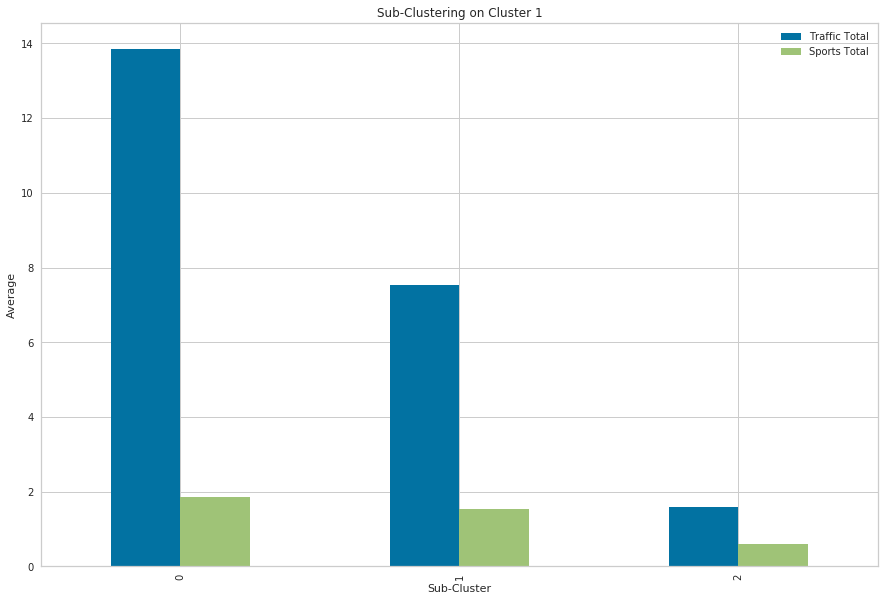

In [199]:
#Plot the bar chart
bar1.plot(kind='bar',figsize=(15,10))
plt.xlabel('Sub-Cluster')
plt.ylabel('Average')
plt.title('Sub-Clustering on Cluster 1')
plt.show()

**Sub-cluster 0 & 1 looks interesting! Let's explore the neighborhoods in these sub-clusters.**

Let's find out which neighborhoods fall under sub-cluster 0.

In [201]:
sub_cls0=cls1_cleaned_complete[cls1_cleaned_complete['Sub-Cluster label']==0]
sub_cls0.reset_index(drop=True,inplace=True)
sub_cls0

,Neighborhood,Sub-Cluster label,Traffic Total,Sports Total,Latitude,Longitude
0,Bukit Bintang,0,15,1,3.147770,101.708550
1,Bukit Nanas,0,12,4,3.151142,101.699375
2,Chow Kit,0,14,1,3.163590,101.698110
3,Dang Wangi,0,15,3,3.156685,101.698077
4,"Kampung Baru, Kuala Lumpur",0,12,0,3.165460,101.710280
5,Medan Tuanku,0,15,2,3.159260,101.698340
6,Taman U-Thant,0,14,2,3.157700,101.724520


Let's find out which neighborhoods fall under sub-cluster 1.

In [204]:
sub_cls1=cls1_cleaned_complete[cls1_cleaned_complete['Sub-Cluster label']==1]
sub_cls1.reset_index(drop=True,inplace=True)
sub_cls1

,Neighborhood,Sub-Cluster label,Traffic Total,Sports Total,Latitude,Longitude
0,"Ampang, Kuala Lumpur",1,9,2,3.148494,101.696729
1,Bangsar,1,10,0,3.129200,101.678440
2,Bangsar Park,1,10,0,3.129200,101.678440
3,Bangsar South,1,6,2,3.111020,101.662830
4,"Batu, Kuala Lumpur",1,7,2,3.147890,101.694050
5,Brickfields,1,10,2,3.129160,101.684060
6,Bukit Petaling,1,7,1,3.129290,101.698960
7,Bukit Tunku,1,6,2,3.173810,101.682760
8,Damansara Town Centre,1,8,2,3.136442,101.690296
9,"Damansara, Kuala Lumpur",1,8,1,3.141906,101.679678


## Results & Discussion <a id='Results'></a>

As written at the business problem section, the investor is looking for neighborhood with the following conditions:

* Area that is not already crowded with gyms
* Area that has hotels or shopping mall or residential (apartments or condo) in vicinity.

By using location data provided by Foursquare, we have selected neighborhoods with shopping malls, hotels or residentials(apartment or condo) and of course sports venues. Using machine learning (KMeans clustering) algorithm, these neighborhoods are segmented into 3 clusters.

Taking close view on the clusters' details, it's noticed that these clusters could be described as below:

* Cluster 0  - Moderate number of traffic attraction venues (malls/hotel/apartments), high amount of sports amenities, with 
* Cluster 1  - High amount of traffic attraction venues , moderate amount of sports amenities 
* Cluster 2  - Low amount of traffic attraction venues, low amount of sports amenities


Cluster 1 seems to match the selection criteria. By taking a close view on the cluster 1, it seems there is possibility to perform clustering again internally within cluster 1. Cluster 1 is then sub-segmented into 3 sub-clusters, with description as below:

|Sub-cluster|Number of Traffic Attraction Venues|Number of Sports Venues|
|:--:|:--|:--|
|0|highest|highest|
|1|2nd|2nd|
|2|lowest|lowest|

The sub-clusters distribution are visualized on the map. It shows that sub-cluster 0 are located in the city center of Kuala Lumpur, which explain the observation of high number of traffic attraction venues (shopping malls / hotels/ residential etc).


Based on the results and selection criteria, it's recommended that neighborhoods in sub-cluster 0 & sub-cluster 1 should be considered. Of course, there are many other factors to consider such as rental price, transportation etc which are not in the scope of this project. 



### Limitation

There are some limitations in this projects, which can be further improved should this project is extended.They are as listed below:

1. The traffic attraction is assumed by the number of venues(such as hotels, shopping malls etc). Some factors which contribute to traffic attraction are not considered in this approach, such as the attractiveness of venues, capacity of these venues, transportation etc. 

2. There are other venues with high traffics, such as corporate offices, which are not listed in Foursquare returned data. 

3. The competitors are not studied in details (such as distances, pricing, rating etc)

4. There are other determining factors besides the selection criteria listed, which is not in the scope of this project.



## Conclusion <a id='Conclusion'></a>

Utilizing Foursquare location data complemented with neighborhood list from Wikipedia, the data are collected and pre-processed prior to analysis. By running machine learning(KMeans) algorithm, the neighborhoods are segmented into 3 clusters. 

One potential cluster (cluster 1) is identified. Further analysis on cluster 1 has shown that this cluster can be further sub-segmented into 3 sub-clusters.  Sub-clusters 0 and 1 are identified as clusters matching the selection criteria.

The neighborhoods in sub-cluster 0 & 1 in the cluster 1 are recommended to investor.